In [1]:
import ROOT as r
import numpy as np
import math

Welcome to JupyROOT 6.22/00


### Comparing simulation yields to data

Often we want to compare the event yields of simulation samples to actual data, to see if number of events you get from data matches what your simulation predicts.

To relate the two numbers (MC yields v.s. data), we just have to remember the expected number of events from any process at LHC is given by

$$ N = L \times \sigma \times Br$$
where 

$\begin{align}
L      &= \text{integrated luminosity of data collected} \\ 
\sigma &= \text{cross section of the process}\\
Br     &= \text{Branching ratio of the process into specific final states}
\end{align}
$ 

For example, if a process A has a cross section of 1 fb, and you have collected 10 /fb of data, the expected number of events in data would be 10 events.
If you have generated 50 simuated events (more than what you expect in data), you simply need to scale each event with a weight of w,

$\begin{align}
w &= (L \times \sigma )/ N_{sample} \\
   &  = 10 \times 1 / 50\\
    & = 0.2
     \end{align}
$

Let's see how to do this in ROOT in practice.

### Filling a histogram with a weight

In [2]:
c = r.TCanvas('c1','c1',800,600)
h = r.TH1F('h_test','Test',10,0,10)

In [3]:
h.Fill(5,2)

6

In [4]:
h.GetEntries()

1.0

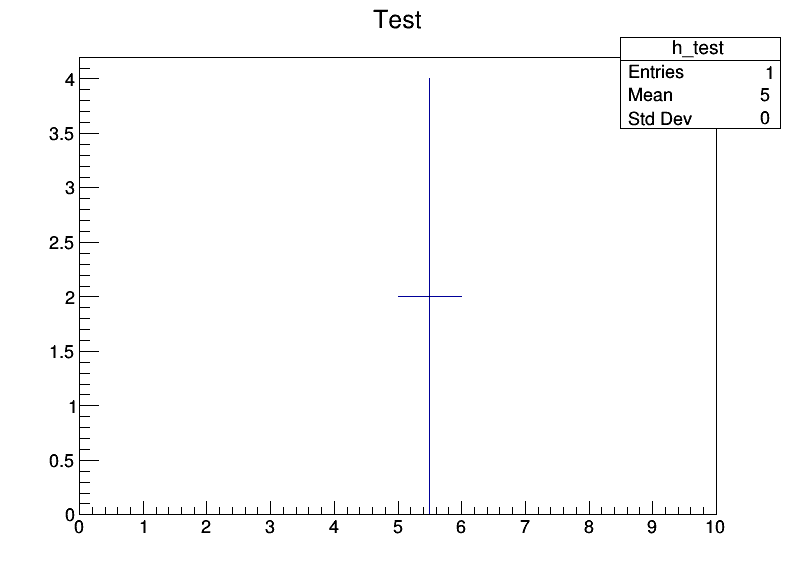

In [5]:
h.Draw()
c.Draw()

### Comparing Z-peak from simulation with data

Let's do a concrete exercise with the dataset we have at hand.

The cross-section for the simulation dataset (`DYToMuMu_M-20_CT10_8TeV-powheg-pythia6`) is **1870** pb, since the Z-boson is set to decay to muons during the event generation, the branching ratio has been incoporated in the cross section value.

As for the data, the full luminosity of 2012 data-taking runs is around 20 fb$^{-1}$, but we are only processing a fraction of the data. If we sum up the luminosity collected in the released data, that corresponds to a luminosity of 4.42 fb$^{-1}$ = **4420** pb$^{-1}$

Therefore, the expected total number of Z-to-mumu events in the data is 

$
\begin{align}
   N = 1870 * 4420 = 8265400
\end{align}
$

[1] Open data record for MC dataset : http://opendata.cern.ch/record/7741

[2] Open data record for parked data: http://opendata.cern.ch/record/7741

In [3]:
## Getting the data-files as before
dy_mc      = r.TFile('dy_mc.root')
data       = r.TFile("Run2012B_DoubleMuParked_nanoaod.root")

In [4]:
## Let's check the number of events in each file
## The simulation dataset is small enough to be processed in this notebook
dy_mc.Get('aod2nanoaod/Events').GetEntries()

239370L

In [5]:
#For the datafile, we are processing only a fraction of all the data

In [6]:
data.Get('aod2nanoaod/Events').GetEntries()

16922L

#### How much luminosity do we have in this datafile?

From (http://opendata.cern.ch/record/7741), the full luminosity 4.42 fb$^{-1}$ corresponds to 29,308,627 events.

Therefore, by simple proportion, 16,922 corresponds to 0.002551 fb$^{-1}$ or **2.551** pb$^{-1}$

In [30]:
N_mc     = 50000   #For the sake of processing time, let's process only 50k MC events
xSection = 1870.4

fulldata = 29308627
tinydata = data.Get('aod2nanoaod/Events').GetEntries()

lumi = (4.42 *1000)*tinydata/fulldata
print('Effective luminosity of in this file is %.4f pb \n'%lumi)

print('Expected number of Z-to-mu-mu events in this file is %.4f \n'%(lumi* xSection))

weight = lumi * xSection / (N_mc) 
print('We should weight each event in the simulation by a factor of %.4f'%weight)

Effective luminosity of in this file is 2.5520 pb 

Expected number of Z-to-mu-mu events in this file is 4773.2368 

We should weight each event in the simulation by a factor of 0.0955


### Setting up the event-loop

In [17]:
## Same functions as before
def invmass(pt,phi,eta,mass):
    m = 0
    px = pt[0]*np.cos(phi[0])+pt[1]*np.cos(phi[1])
    py = pt[0]*np.sin(phi[0])+pt[1]*np.sin(phi[1])
    theta0 = 2.*np.arctan(np.exp(-eta[0]))
    theta1 = 2.*np.arctan(np.exp(-eta[1]))
    pz = pt[0]/np.tan(theta0) + pt[1]/np.tan(theta1)
    e0 = np.sqrt(pt[0]**2 + (pt[0]/np.tan(theta0))**2 + mass[0]**2)
    e1 = np.sqrt(pt[1]**2 + (pt[1]/np.tan(theta1))**2 + mass[1]**2)
    
    m = np.sqrt((e0+e1)**2 - px**2 - py**2 - pz**2)
    return m

def deltaPhi(phi1, phi2):
    x = np.abs(phi1 - phi2)
    if x >=  math.pi: 
        x = 2.*math.pi - x
    return x

def selectMuons(muons):
    select = False
    if (muons['n']==2 and np.all(muons['isTight'])
        and muons['charge'][0]*muons['charge'][1]<0
        and muons['pt'][0]>25 and muons['pt'][1]>10
        and abs(muons['eta'][0])<2.1 and abs(muons['eta'][1])<2.4
        and muons['iso'][0]<0.12 and muons['eta'][1]<0.2):
            select = True
    return select

### Define the histograms to contain the results

In [9]:
h_dimuon_mass_mc   = r.TH1F('DiMuon_mass_mc','DiMuon_mass_mc',50,80,100)
h_dimuon_mass_data = r.TH1F('DiMuon_mass_data','DiMuon_mass_data',50,80,100)

h_dimuon_mass_mc.Sumw2()
h_dimuon_mass_data.Sumw2()

In [18]:
h_dimuon_mass_data.Reset()
h_dimuon_mass_mc.Reset()

### Define a function to fill the histogram

We want to process the simulation and data in the exact same way, in order for them to match.

Therefore, we can define a function, taking a `TTree` as input, with `weight` and number of events to process `N` as arguments

In [10]:
def FillHistogram(t,h_dimuon_mass,weight,N=-1):
    if N==-1:
        #Process all the events by default
        nEntries = t.GetEntries()
    else:
        nEntries = N
    print('Processing %s events in the tree'%nEntries)
    for i in range(0,nEntries):
        t.GetEntry(i)
        nMuon   = t.nMuon
        pt      = np.array(t.Muon_pt)          # note: this is an array
        phi     = np.array(t.Muon_phi)         # note: this is an array
        eta     = np.array(t.Muon_eta)         # note: this is an array 
        mass    = np.array(t.Muon_mass)        # note: this is an array
        isTight = np.array(t.Muon_tightId)     # note: this is an array
        charge  = np.array(t.Muon_charge)      # note: this is an array
        iso     = np.array(t.Muon_pfRelIso04_all)
        muons   = {
            'n':nMuon,
            'pt':pt,
            'phi':phi,
            'eta':eta,
            'isTight':isTight,
            'charge':charge,
            'iso':iso,
        }
        if selectMuons(muons):
            h_dimuon_mass.Fill(invmass(pt,phi,eta,mass),weight)

    h_dimuon_mass.GetXaxis().SetTitle('m_{#mu#mu}[GeV]')
    return 

In [11]:
# get the tree from the file
t_mc = dy_mc.Get('aod2nanoaod/Events')
t_data = data.Get('aod2nanoaod/Events')

In [19]:
# For simulation, we want to fill the histogram with a weight we have computed before
FillHistogram(t_mc,h_dimuon_mass_mc,weight,N_mc)

Processing 50000 events in the tree


In [20]:
# For data, we want to set the weight to 1.0
FillHistogram(t_data,h_dimuon_mass_data,1.0)

Processing 16922 events in the tree


### Finally, let's draw both histogram together for comparison

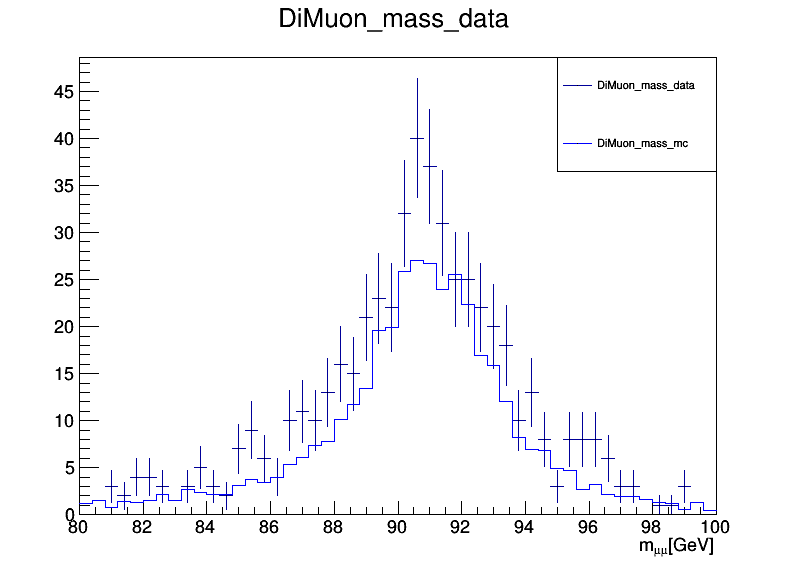

In [21]:
h_dimuon_mass_data.SetStats(0)
h_dimuon_mass_mc.SetLineColor(r.kBlue)
h_dimuon_mass_mc.SetFillColor(0)
h_dimuon_mass_data.Draw()
h_dimuon_mass_mc.Draw('same hist')
c.Draw()
c.BuildLegend(0.7,0.7,0.9,0.9)

The data-MC agreement is not bad with this very simple example.


As the data sample is very tiny, fluctuation in data could make the comparison with simulation difficult.

### Dataset for H to 4l analysis

With the above knowledge, you can process the simulation files in the H to 4l analysis and compare them with data.

Here are the relevant data that you will need to compute the weights for respective simulation samples.

Can you compute the weights below?

| Sample Name  | cross-section(pb)  | Nevents  |
|---       | ---                | --- |
|ZZto4mu   |   7.6865000E-02    | 1499064  |
|ZZto4e    |   7.7241300E-02    | 1499093  |
|ZZto2e2mu |   1.7656500E-01    | 1497445  |
|DYJets    |   2.7903452E+03    | 30458871 |
|SMHiggs   |   1.2932700E+01    | 299973   |

|Dataset | Luminosity(/pb)|
|---| ---|
|2012B |4410|
|2012C |7060|

In [21]:
### Compute the weights here

#### Extension: To handle more than 1 histograms, you may use a more generic function like this

In [22]:
def FillHistogram_extended(t,histograms,weight,N=-1):
    if N==-1:
        #Process all the events by default
        nEntries = t.GetEntries()
    else:
        nEntries = N
    print('Processing %s events in the tree'%nEntries)
    for i in range(0,nEntries):
        t.GetEntry(i)
        nMuon   = t.nMuon
        pt      = np.array(t.Muon_pt)          # note: this is an array
        phi     = np.array(t.Muon_phi)         # note: this is an array
        eta     = np.array(t.Muon_eta)         # note: this is an array 
        mass    = np.array(t.Muon_mass)        # note: this is an array
        isTight = np.array(t.Muon_tightId)     # note: this is an array
        charge  = np.array(t.Muon_charge)      # note: this is an array
        iso     = np.array(t.Muon_pfRelIso04_all)
        muons   = {
            'n':nMuon,
            'pt':pt,
            'phi':phi,
            'eta':eta,
            'isTight':isTight,
            'charge':charge,
            'iso':iso
        }
        quantity={}
        if selectMuons(muons):
            quantity['mass']=invmass(pt,phi,eta,mass)
            quantity['pt0'] =muons['pt'][0]
            for histogram in histograms:
                histogram['h'].Fill(quantity[histogram['fill_var']],weight)
            #h_dimuon_mass.Fill(invmass(pt,phi,eta,mass),weight)
    return 

In [24]:
h_dimuon_mass_mc   = r.TH1F('DiMuon_mass_mc','DiMuon_mass_mc',50,80,100)
h_dimuon_pt0_mc   = r.TH1F('DiMuon_pt_mc','DiMuon_pt_mc',50,0,200)

h_dimuon_mass_data  = r.TH1F('DiMuon_mass_data','DiMuon_mass_data',50,80,100)
h_dimuon_pt0_data   = r.TH1F('DiMuon_pt_data','DiMuon_pt_data',50,0,200)


h_mc_list = [
    {'h':h_dimuon_mass_mc, 'fill_var':"mass"},
    {'h':h_dimuon_pt0_mc, 'fill_var':"pt0"},
]
h_data_list = [
    {'h':h_dimuon_mass_data, 'fill_var':"mass"},
    {'h':h_dimuon_pt0_data, 'fill_var':"pt0"},
]
for hist in h_mc_list+h_data_list:
    hist['h'].Sumw2()

Warning in <TFile::Append>: Replacing existing TH1: DiMuon_mass_mc (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: DiMuon_mass_data (Potential memory leak).


In [25]:
FillHistogram_extended(t_mc,h_mc_list,weight,N_mc)

Processing 50000 events in the tree


In [26]:
FillHistogram_extended(t_data,h_data_list,1.0)

Processing 16922 events in the tree


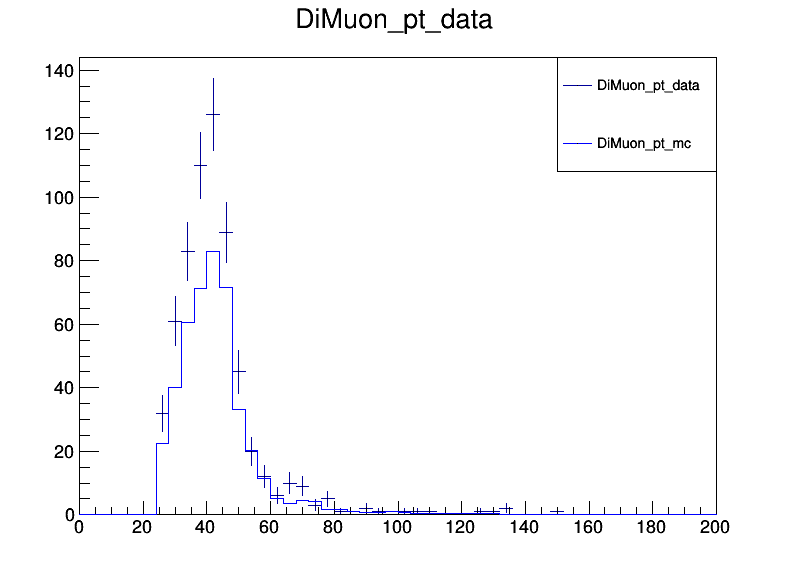

In [27]:
h_dimuon_pt0_data.SetStats(0)
h_dimuon_pt0_mc.SetLineColor(r.kBlue)
h_dimuon_pt0_mc.SetFillColor(0)
h_dimuon_pt0_data.Draw()
h_dimuon_pt0_mc.Draw('same hist')
c.Draw()
c.BuildLegend(0.7,0.7,0.9,0.9)

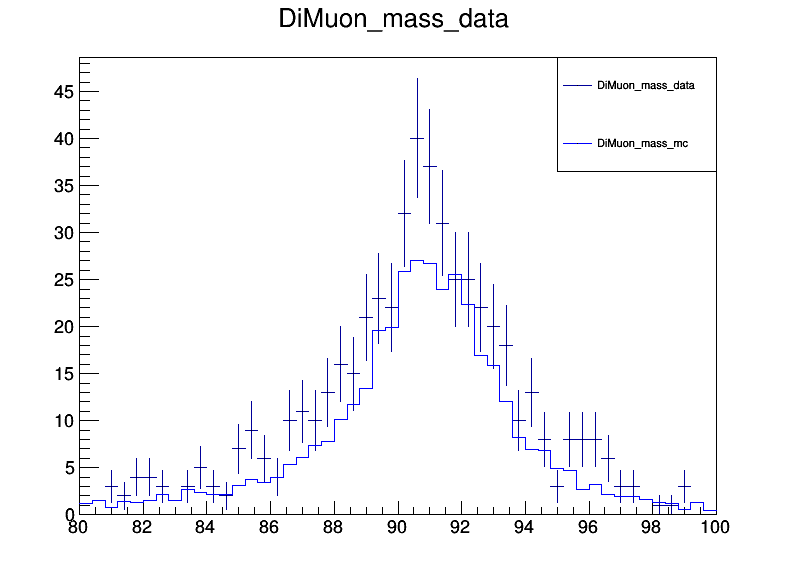

In [28]:
h_dimuon_mass_data.SetStats(0)
h_dimuon_mass_mc.SetLineColor(r.kBlue)
h_dimuon_mass_mc.SetFillColor(0)
h_dimuon_mass_data.Draw()
h_dimuon_mass_mc.Draw('same hist')
c.Draw()
c.BuildLegend(0.7,0.7,0.9,0.9)

In [29]:
for hist in h_mc_list+h_data_list:
    hist['h'].Reset()